<a href="https://colab.research.google.com/github/irfansaleem541/fintech_irfan/blob/main/Fintech_irfan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1357535829.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
/tmp/ipython-input-1357535829.py:39: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices_m.sort_index().pct_change()
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/tmp/ipython-input-1357535829.py:92: RuntimeWarning: invalid value encountered in divide
  dd = equity / peak - 1
/tmp/ipython-input-1357535829.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')



=== Baseline Portfolio Performance ===
PerfMetrics(cagr=np.float64(inf), ann_vol=np.float64(nan), sharpe=np.float64(nan), sortino=np.float64(nan), max_drawdown=np.float64(nan), calmar=np.float64(nan), hit_ratio=np.float64(0.3185840707964602))
Saved plot: outputs/portfolio_vs_index.png


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



[Info] FinBERT step skipped (no pipeline or no 'News' sheet). The baseline portfolio remains available.

Saved CSVs to 'outputs/'.


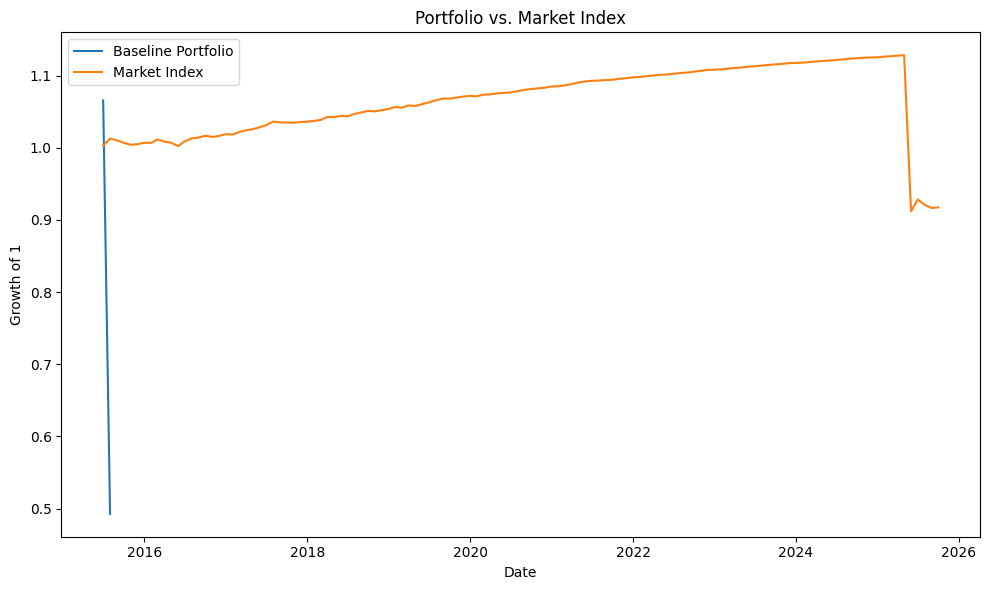

In [1]:
from __future__ import annotations

import os
from dataclasses import dataclass
from typing import Dict, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------- Configuration --------------------
EXCEL_PATH = "updated_Test_Portfolio.xlsx"  # change if needed
PRICE_SHEET = "Price and Returns"
INDEX_SHEET = "Market Index"  # optional
NEWS_SHEET = "News"  # optional: [date, ticker, headline]
DATE_COL = "Date"
MONTHS_PER_YEAR = 12
RF_ANNUAL = 0.00  # set your annual risk‑free rate (e.g., 0.03)
OUTPUT_DIR = "outputs"

# Sentiment tilt params
SENTIMENT_USE_SOFTMAX = True
SENTIMENT_STRENGTH = 2.0  # higher magnifies differences
MIN_WEIGHT_FLOOR = 0.02   # floor per asset when tilting

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------- Utilities --------------------

def to_month_end(df: pd.DataFrame) -> pd.DataFrame:
    """Resample to month-end and take the last valid observation within the month."""
    return (df
            .resample('M')
            .last()
            .dropna(how='all'))


def compute_returns(prices_m: pd.DataFrame) -> pd.DataFrame:
    returns = prices_m.sort_index().pct_change()
    return returns.dropna(how='all')


def normalize_weights(weights: pd.Series) -> pd.Series:
    w = weights.copy().astype(float)
    w[w < 0] = 0
    if w.sum() == 0:
        return pd.Series(np.repeat(1/len(w), len(w)), index=w.index)
    return w / w.sum()


def rolling_cummax(arr: np.ndarray) -> np.ndarray:
    return np.maximum.accumulate(arr)

@dataclass
class PerfMetrics:
    cagr: float
    ann_vol: float
    sharpe: float
    sortino: float
    max_drawdown: float
    calmar: float
    hit_ratio: float


def performance_metrics(monthly_returns: pd.Series, rf_annual: float = RF_ANNUAL) -> PerfMetrics:
    """Compute standard performance metrics from monthly returns (pd.Series)."""
    r = monthly_returns.dropna()
    if r.empty:
        return PerfMetrics(*([np.nan]*7))

    # CAGR
    total_return = (1 + r).prod()
    n_years = len(r) / MONTHS_PER_YEAR
    cagr = total_return ** (1 / n_years) - 1 if n_years > 0 else np.nan

    # Annualized volatility
    ann_vol = r.std(ddof=0) * np.sqrt(MONTHS_PER_YEAR)

    # Sharpe (monthly rf derived from annual)
    rf_monthly = (1 + rf_annual) ** (1 / MONTHS_PER_YEAR) - 1
    excess = r - rf_monthly
    sharpe = excess.mean() / r.std(ddof=0) * np.sqrt(MONTHS_PER_YEAR) if r.std(ddof=0) != 0 else np.nan

    # Sortino
    downside = r[r < 0]
    downside_std = downside.std(ddof=0)
    sortino = excess.mean() / downside_std * np.sqrt(MONTHS_PER_YEAR) if downside_std not in (0, np.nan) else np.nan

    # Max drawdown & Calmar
    equity = (1 + r).cumprod().values
    peak = rolling_cummax(equity)
    dd = equity / peak - 1
    max_dd = dd.min() if len(dd) else np.nan
    calmar = cagr / abs(max_dd) if max_dd not in (0, np.nan) else np.nan

    # Hit ratio
    hit_ratio = (r > 0).mean() if len(r) else np.nan

    return PerfMetrics(cagr, ann_vol, sharpe, sortino, max_dd, calmar, hit_ratio)


# -------------------- Loading --------------------

def load_data(xlsx_path: str = EXCEL_PATH,
              price_sheet: str = PRICE_SHEET,
              index_sheet: Optional[str] = INDEX_SHEET,
              news_sheet: Optional[str] = NEWS_SHEET
             ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    xls = pd.read_excel(xlsx_path, sheet_name=None)

    if price_sheet not in xls:
        raise ValueError(f"Sheet '{price_sheet}' not found. Available: {list(xls.keys())}")

    price_df = xls[price_sheet].copy()
    if DATE_COL not in price_df.columns:
        raise ValueError(f"'{DATE_COL}' column is required in '{price_sheet}'.")

    price_df[DATE_COL] = pd.to_datetime(price_df[DATE_COL])
    price_df = price_df.set_index(DATE_COL).sort_index()

    # Clean numeric columns
    for c in price_df.columns:
        price_df[c] = pd.to_numeric(price_df[c], errors='coerce')

    # Optional index DF
    index_df = None
    if index_sheet and index_sheet in xls:
        index_df = xls[index_sheet].copy()
        # try infer index column name
        idx_cols = [c for c in index_df.columns if c.lower() != DATE_COL.lower()]
        if DATE_COL not in index_df.columns or not idx_cols:
            # try alternative: if Market Index is a column in price_df
            index_df = None
        else:
            index_df[DATE_COL] = pd.to_datetime(index_df[DATE_COL])
            index_df = index_df.set_index(DATE_COL).sort_index()
            for c in index_df.columns:
                index_df[c] = pd.to_numeric(index_df[c], errors='coerce')

    # Optional news DF for FinBERT
    news_df = None
    if news_sheet and news_sheet in xls:
        news_df = xls[news_sheet].copy()
        # Expect [date, ticker, headline]
        # Best-effort cleanup
        dcol = None
        for cand in ["date", "Date", "DATE"]:
            if cand in news_df.columns:
                dcol = cand
                break
        tcol = None
        for cand in ["ticker", "Ticker", "bank", "Bank", "symbol"]:
            if cand in news_df.columns:
                tcol = cand
                break
        hcol = None
        for cand in ["headline", "news", "text", "Title", "title"]:
            if cand in news_df.columns:
                hcol = cand
                break
        if dcol and tcol and hcol:
            news_df = news_df[[dcol, tcol, hcol]].rename(columns={dcol:"date", tcol:"ticker", hcol:"headline"})
            news_df['date'] = pd.to_datetime(news_df['date'])
        else:
            news_df = None

    return price_df, index_df, news_df


# -------------------- Portfolio Construction --------------------

def build_equal_weight_portfolio(returns_m: pd.DataFrame) -> pd.Series:
    assets = returns_m.columns
    w = pd.Series(1/len(assets), index=assets)
    port_r = (returns_m * w).sum(axis=1)
    return port_r


def build_weighted_portfolio(returns_m: pd.DataFrame, weights: Dict[str, float]) -> pd.Series:
    w = pd.Series(weights)
    # keep only available assets
    w = w.reindex(returns_m.columns).fillna(0)
    w = normalize_weights(w)
    return (returns_m * w).sum(axis=1)


# -------------------- FinBERT Sentiment --------------------

def try_load_finbert_pipeline():
    """Return a transformers pipeline for finance sentiment or None if unavailable."""
    try:
        from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
        model_name = "ProsusAI/finbert"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, truncation=True)
        return pipe
    except Exception as e:
        print(f"[FinBERT] Unavailable ({e}). Skipping sentiment step.")
        return None


def score_sentiment_monthly(news_df: pd.DataFrame, pipe) -> pd.DataFrame:
    """Compute monthly sentiment per ticker from a News dataframe [date, ticker, headline].
    Returns wide DF indexed by month-end with tickers as columns, scores in [-1, 1].
    """
    if news_df is None or pipe is None or news_df.empty:
        return pd.DataFrame()

    df = news_df.dropna(subset=['date', 'ticker', 'headline']).copy()
    df['month'] = df['date'].values.astype('datetime64[M]') + np.timedelta64(1, 'M') - np.timedelta64(1, 'D')

    scores = []
    for _, row in df.iterrows():
        text = str(row['headline'])[:512]
        try:
            preds = pipe(text)[0]  # list of dicts: [{'label': 'positive', 'score': ...}, ...]
            label_scores = {d['label'].lower(): d['score'] for d in preds}
            # Convert to a polarity in [-1, 1]
            pos = label_scores.get('positive', 0)
            neg = label_scores.get('negative', 0)
            neu = label_scores.get('neutral', 0)
            polarity = pos - neg  # range ~[-1, 1]
        except Exception:
            polarity = 0.0
        scores.append((row['month'], row['ticker'], polarity))

    sdf = pd.DataFrame(scores, columns=['month', 'ticker', 'polarity'])
    monthly = sdf.groupby(['month', 'ticker'])['polarity'].mean().unstack('ticker').sort_index()
    monthly.index = pd.to_datetime(monthly.index)
    return monthly


def sentiment_tilt_weights(sent_scores: pd.DataFrame, assets: list[str]) -> pd.DataFrame:
    """Turn monthly sentiment scores into monthly weight vectors over 'assets'."""
    if sent_scores is None or sent_scores.empty:
        return pd.DataFrame()

    sent = sent_scores.reindex(columns=assets).fillna(0.0)

    weights_list = []
    for dt, row in sent.iterrows():
        s = row.fillna(0.0)
        if SENTIMENT_USE_SOFTMAX:
            x = np.exp(SENTIMENT_STRENGTH * s.values)
            w = x / x.sum() if x.sum() > 0 else np.repeat(1/len(s), len(s))
        else:
            w = s.values - s.values.min()
            if w.sum() == 0:
                w = np.repeat(1/len(s), len(s))
            else:
                w = w / w.sum()
        # apply floor
        w = np.maximum(w, MIN_WEIGHT_FLOOR)
        w = w / w.sum()
        weights_list.append(pd.Series(w, index=assets, name=dt))

    W = pd.DataFrame(weights_list)
    return W


def backtest_dynamic_weights(returns_m: pd.DataFrame, weights_m: pd.DataFrame) -> pd.Series:
    """Backtest a portfolio with weights that change monthly. Assumes weights at month t apply to t returns."""
    aligned_r = returns_m.loc[weights_m.index]
    aligned_w = weights_m.reindex(index=aligned_r.index, columns=aligned_r.columns).fillna(0)
    port_r = (aligned_r * aligned_w).sum(axis=1)
    return port_r


# -------------------- Plotting --------------------

def plot_equity_curves(curves: Dict[str, pd.Series], title: str, fname: str):
    plt.figure(figsize=(10, 6))
    for label, series in curves.items():
        eq = (1 + series.dropna()).cumprod()
        plt.plot(eq.index, eq.values, label=label)
    plt.title(title)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Growth of 1')
    plt.tight_layout()
    outpath = os.path.join(OUTPUT_DIR, fname)
    plt.savefig(outpath, dpi=150)
    print(f"Saved plot: {outpath}")


# -------------------- Main pipeline --------------------

def main(xlsx_path: str = EXCEL_PATH, custom_weights: Optional[Dict[str, float]] = None):
    # Load
    prices_d, index_df, news_df = load_data(xlsx_path)

    # Convert daily to monthly (last close of month)
    prices_m = to_month_end(prices_d)

    # Compute monthly returns
    rets_m = compute_returns(prices_m)

    # Build portfolio returns
    if custom_weights:
        port_r = build_weighted_portfolio(rets_m, custom_weights)
    else:
        port_r = build_equal_weight_portfolio(rets_m)

    # Performance metrics
    pm = performance_metrics(port_r)
    print("\n=== Baseline Portfolio Performance ===")
    print(pm)

    # Market Index handling
    index_r = None
    if index_df is not None and not index_df.empty:
        idx_name = [c for c in index_df.columns if c.lower() != DATE_COL.lower()]
        if idx_name:
            idx_col = idx_name[0]
            idx_m = to_month_end(index_df[[idx_col]])
            index_r = idx_m[idx_col].pct_change().dropna()

    # Plot baseline vs index if available
    curves = {"Baseline Portfolio": port_r}
    if index_r is not None and not index_r.empty:
        curves["Market Index"] = index_r.reindex(port_r.index).dropna()
    plot_equity_curves(curves, "Portfolio vs. Market Index", "portfolio_vs_index.png")

    # -------------------- FinBERT combo (optional) --------------------
    pipe = try_load_finbert_pipeline()
    if pipe is not None and news_df is not None and not news_df.empty:
        sent_m = score_sentiment_monthly(news_df, pipe)
        # align sentiment months to returns months
        sent_m = sent_m.reindex(index=rets_m.index, method=None).dropna(how='all')
        if not sent_m.empty:
            W = sentiment_tilt_weights(sent_m, assets=list(rets_m.columns))
            W = W.reindex(index=rets_m.index).dropna(how='any')
            if not W.empty:
                port_r_tilt = backtest_dynamic_weights(rets_m, W)
                pm_tilt = performance_metrics(port_r_tilt)
                print("\n=== Sentiment‑Tilted Portfolio Performance ===")
                print(pm_tilt)
                # Plot comparison
                plot_equity_curves({"Baseline": port_r, "Sentiment‑Tilted": port_r_tilt},
                                   "Baseline vs. Sentiment‑Tilted Portfolio",
                                   "baseline_vs_sentiment_tilt.png")
    else:
        print("\n[Info] FinBERT step skipped (no pipeline or no 'News' sheet). The baseline portfolio remains available.")

    # Save key outputs
    prices_m.to_csv(os.path.join(OUTPUT_DIR, "monthly_prices.csv"))
    rets_m.to_csv(os.path.join(OUTPUT_DIR, "monthly_returns.csv"))
    pd.DataFrame({"portfolio_returns": port_r}).to_csv(os.path.join(OUTPUT_DIR, "portfolio_returns.csv"))
    print(f"\nSaved CSVs to '{OUTPUT_DIR}/'.")

/tmp/ipython-input-1357535829.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
/tmp/ipython-input-1357535829.py:39: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices_m.sort_index().pct_change()
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/tmp/ipython-input-1357535829.py:92: RuntimeWarning: invalid value encountered in divide
  dd = equity / peak - 1
/tmp/ipython-input-1357535829.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')



=== Baseline Portfolio Performance ===
PerfMetrics(cagr=np.float64(inf), ann_vol=np.float64(nan), sharpe=np.float64(nan), sortino=np.float64(nan), max_drawdown=np.float64(nan), calmar=np.float64(nan), hit_ratio=np.float64(0.3185840707964602))
Saved plot: outputs/portfolio_vs_index.png


Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



[Info] FinBERT step skipped (no pipeline or no 'News' sheet). The baseline portfolio remains available.

Saved CSVs to 'outputs/'.


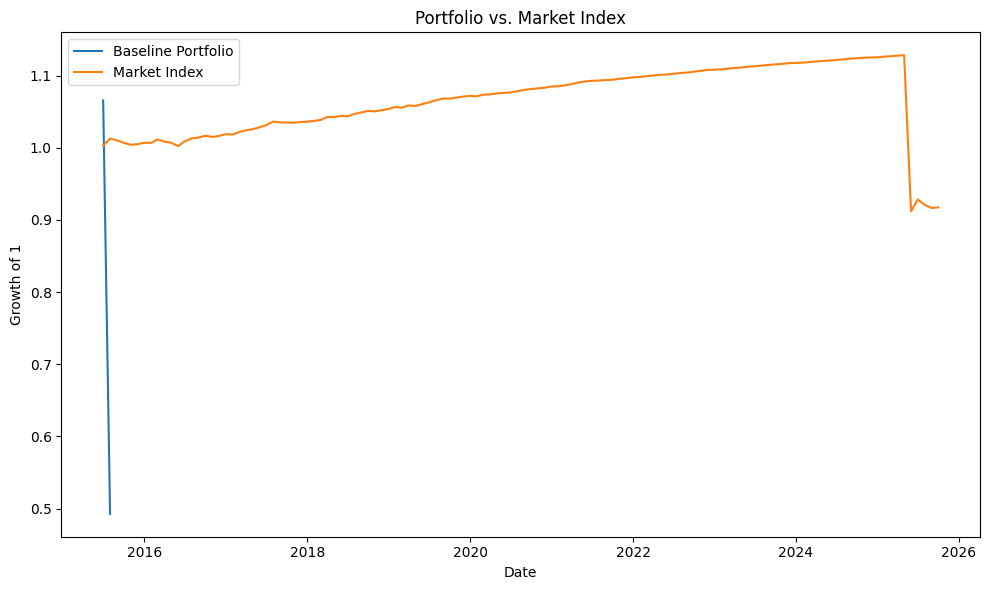

In [2]:
main(EXCEL_PATH, custom_weights=None)